# Breast cancer case

In [2]:
import numpy as np
import pandas as pd
import feyn

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../../dirac/dirac/crossval/')
from _crossvalidation import crossvalidation_as_framework

In [10]:
feyn.__version__

'2.1.2'

### Load and prep data

In [3]:
data = pd.read_csv('../data/brca_data_w_meta.csv')

In [4]:
# Define the target variable
target = "vital.status"

In [5]:
stypes = {}
for f in data.columns:
    if data[f].dtype == 'object':
        stypes[f] = 'c'

### 2 feature models

In [14]:
results = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 50,
                                     criterion='bic',
                                     max_complexity = 3)

In [15]:
results.groupby("fold").first().roc_auc_val.mean(), results.roc_auc_val.mean()

(0.6353392366250381, 0.6308307826966679)

In [16]:
results.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1
fold,,,,,,,,,
0,logreg(rsCHST9*rsPCK1),647.344838,656.014947,0.665417,0.757092,0.659440,0.730496,0.346362,0.235294
1,logreg(rsAPOB*rsGPM6A),634.402481,643.072589,0.722427,0.773050,0.588870,0.737589,0.209888,0.232258
2,logreg(exp(-rsLOC283392**2 - rsOXTR**2)),635.943571,653.283788,0.665003,0.868794,0.537964,0.836879,0.226175,0.236842
3,logreg(exp(-rsMRAP**2 - rsOXTR**2)),660.672829,678.013046,0.629475,0.858156,0.682916,0.879433,0.437718,0.246753
4,logreg(rsACVR1C*rsHEPACAM2),667.311813,675.981921,0.731888,0.755319,0.707506,0.758865,0.457274,0.236842


In [17]:
for model in results.groupby("fold").first().model_structure:
    print(model)

logreg(rsCHST9*rsPCK1)
logreg(rsAPOB*rsGPM6A)
logreg(exp(-rsLOC283392**2 - rsOXTR**2))
logreg(exp(-rsMRAP**2 - rsOXTR**2))
logreg(rsACVR1C*rsHEPACAM2)


In [246]:
import re

best_models_qstrings = []

for m in results.groupby('fold').first()['model_structure'].values:
    if 'exp' in m and '**2' in m:
        m = re.sub('logreg\(exp\(-(.*)\*\*2 - (.*)\*\*2\)\)', r'gaussian("\1", "\2")', m)
    else:
        m = re.sub('logreg\((.*)\*(.*)\)', r'"\1"*"\2"', m)
    
    m = m.replace('rs', 'rs_')
    best_models_qstrings.append(m)

#### Exploration of best models

In [243]:
ql = feyn.connect_qlattice()

In [247]:
n_folds = 5
random_state = 42
models_trained = []
train_list = []
val_list = []

kfold_test = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)
for i, (train, val) in enumerate(kfold_test.split(data, data[target])):
        train, val = data.iloc[train], data.iloc[val]
        train_list.append(train)
        val_list.append(val)
        
        sample_weights = np.where(train[target] == 1,
                                      np.sum(train[target] == 0) / sum(train[target]), 1)
        
        ql.reset(random_state)
        model = ql.auto_run(train, output_name=target, n_epochs=20, kind = "classification",
                             query_string=best_models_qstrings[i], sample_weights=sample_weights, stypes=stypes)[0]
        models_trained.append(model)

**List of inputs**

In [249]:
inputs_list = []
for m in models_trained:
    for i in m.inputs:
        inputs_list.append(i)
        
inputs_list = list(set(inputs_list))

##### **Clustermap**

In [251]:
corr_inputs = data[inputs_list].corr()

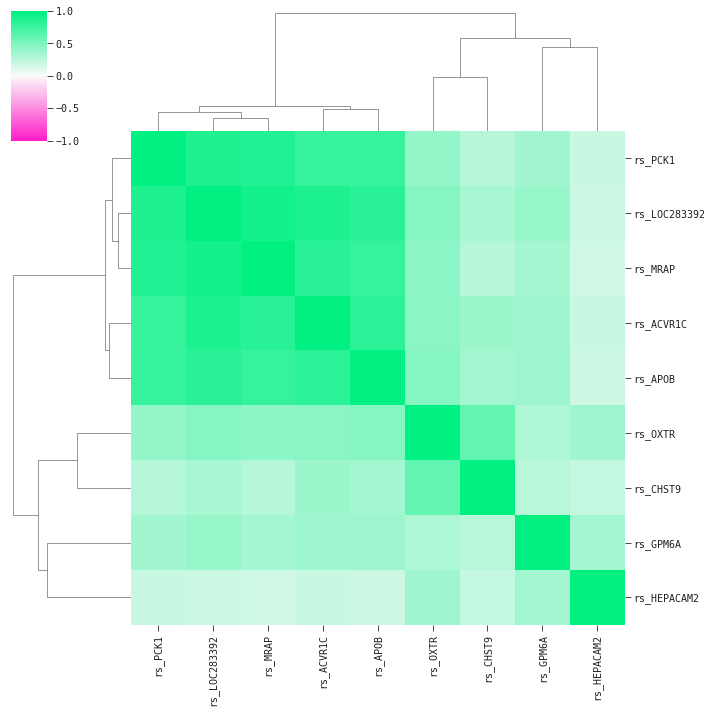

In [253]:
from seaborn import clustermap

cluster_map_args = {'cmap': 'feyn-diverging', 'vmin': -1, 'vmax': 1}

clustermap(corr_inputs, **cluster_map_args)

In [258]:
data[inputs_list].corr()['rs_APOB'].sort_values(ascending=False)

rs_APOB         1.000000
rs_LOC283392    0.835160
rs_ACVR1C       0.822627
rs_MRAP         0.780383
rs_PCK1         0.773892
rs_OXTR         0.466882
rs_GPM6A        0.372880
rs_CHST9        0.349093
rs_HEPACAM2     0.182369
Name: rs_APOB, dtype: float64

Pairwise Pearson correlation within the main group in the heatmap above varies from ~0.77 to ~0.84

##### **Pearson correlation with output `vital.status`**

In [255]:
pd.DataFrame(data[inputs_list].corrwith(data[target]).abs().sort_values(ascending=False), columns=['Pearson corr.'])

,Pearson corr.
rs_APOB,0.269978
rs_LOC283392,0.230158
rs_PCK1,0.224622
rs_MRAP,0.213739
rs_ACVR1C,0.206477
rs_OXTR,0.194393
rs_CHST9,0.138680
rs_GPM6A,0.116361
rs_HEPACAM2,0.051176


##### **Model response (3 examples)**

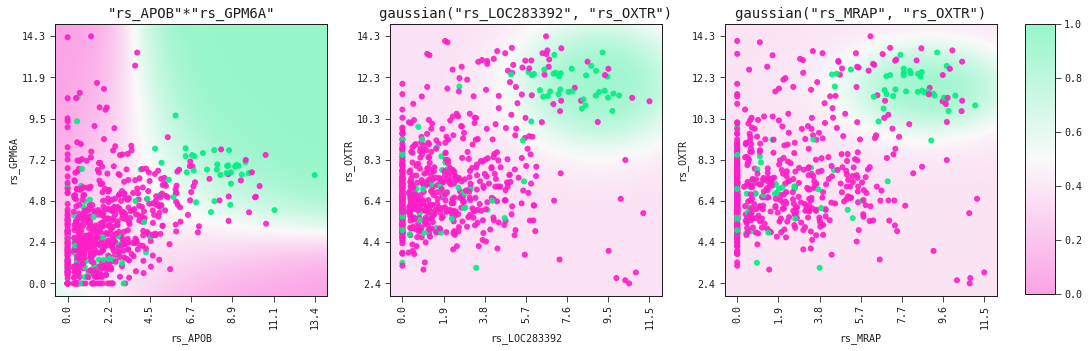

In [262]:
me0, me1, me2 = [1, 2, 3]  # 3 models chosen to be plotted

titles = [best_models_qstrings[me0], best_models_qstrings[me1], best_models_qstrings[me2]]

fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for i, m in enumerate([models_trained[me0], models_trained[me1], models_trained[me2]]):
    m.plot_response_2d(data, ax=axs[i])
    axs[i].set_title(titles[i])

img = axs[i].get_images()[0]
cax = fig.add_axes([0.92, 0.13, 0.025, 0.75])
fig.colorbar(img, cax=cax)
plt.show()

### Larger models

In [116]:
results7 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 100,
                                     max_complexity=7,
                                     criterion='bic')

In [117]:
results7.groupby("fold").first().roc_auc_val.mean(), results7.roc_auc_val.mean()

(0.6216999360100014, 0.6351688564340345)

In [124]:
results7.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1
fold,,,,,,,,,
0,logreg(rsFGFBP1 + rsPIK3C2G*(muITPR2 + rsACVR1C)),624.149066,641.489283,0.774374,0.730496,0.581752,0.695035,0.358006,0.216561
1,logreg(rsAPOB*(cnPRODH + rsC1orf173 + rsHEPACA...,590.162173,607.502390,0.772434,0.776596,0.573339,0.716312,0.203100,0.230769
2,logreg(cnABCC6 + rsSLC7A10*(rsSLC28A3 + rsWNK4)),607.773098,625.113315,0.768616,0.771277,0.600086,0.716312,0.278397,0.240506
3,logreg(rsLOC283392*rsSHISA2*(cnPCSK9 + rsKLK7)),594.728361,616.403632,0.766844,0.774823,0.635030,0.780142,0.248254,0.230769
4,logreg(rsHEPACAM2*(cnFABP7 + rsASCL1 + rsGLYAT)),636.678608,654.018825,0.733306,0.785461,0.718292,0.744681,0.377650,0.248276


In [118]:
for model in results7.groupby("fold").first().model_structure:
    print(model)

logreg(rsFGFBP1 + rsPIK3C2G*(muITPR2 + rsACVR1C))
logreg(rsAPOB*(cnPRODH + rsC1orf173 + rsHEPACAM2))
logreg(cnABCC6 + rsSLC7A10*(rsSLC28A3 + rsWNK4))
logreg(rsLOC283392*rsSHISA2*(cnPCSK9 + rsKLK7))
logreg(rsHEPACAM2*(cnFABP7 + rsASCL1 + rsGLYAT))


In [119]:
results10 = crossvalidation_as_framework(data,
                                     target,
                                     kind = "classification",
                                     stypes = stypes,
                                     n_epochs = 100,
                                     max_complexity=10,
                                     criterion='bic')

In [120]:
results10.groupby("fold").first().roc_auc_val.mean(), results10.roc_auc_val.mean()

(0.62131661955101, 0.6364887066615849)

In [122]:
results10.groupby("fold").first()

,model_structure,aic,bic,roc_auc_train,accuracy_train,roc_auc_val,accuracy_val,pr_auc,f1
fold,,,,,,,,,
0,logreg(rsPTCHD1*(cnADAMTS16 + muDMD + rsFABP4 ...,600.081058,621.756329,0.756606,0.806738,0.558266,0.758865,0.203278,0.220779
1,logreg(rsAPOB*(cnPRODH*(cnCOL14A1 + ppPI3K.p11...,583.045850,609.056175,0.784349,0.801418,0.630285,0.702128,0.219180,0.243590
2,logreg(cnCLCA2 + rsSLC13A2*(cnSLC30A8 + rsAPOB...,599.551998,621.227269,0.761609,0.808511,0.716135,0.815603,0.340016,0.245161
3,logreg(rsTCN1*(ppp27 + rsDEFB132*rsPTPRZ1 + rs...,622.038025,648.048350,0.778350,0.735816,0.577653,0.602837,0.379337,0.248366
4,logreg(cnTNFRSF11B + ppMSH6**2 + rsCYP4Z2P + r...,625.441638,647.116909,0.780177,0.721631,0.624245,0.638298,0.327341,0.235294


In [121]:
for model in results10.groupby("fold").first().model_structure:
    print(model)

logreg(rsPTCHD1*(cnADAMTS16 + muDMD + rsFABP4 + rsSOX2))
logreg(rsAPOB*(cnPRODH*(cnCOL14A1 + ppPI3K.p110.alpha) + rsTAT))
logreg(cnCLCA2 + rsSLC13A2*(cnSLC30A8 + rsAPOB + rsPAX7))
logreg(rsTCN1*(ppp27 + rsDEFB132*rsPTPRZ1 + rsSOX2))
logreg(cnTNFRSF11B + ppMSH6**2 + rsCYP4Z2P + rsPCOLCE2 + rsPLA2G2D)


### Comparison with random forest

In [9]:
df = pd.get_dummies(data)


parameters={'bootstrap': [True, False],
             'ccp_alpha': [0.0],
             'class_weight': ['balanced'],
             'max_depth': [3, 4, 5],
             'max_features': ['auto', 'sqrt'],
             'max_leaf_nodes': [None],
             'max_samples': [None],
             'min_impurity_decrease': [0.0],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [5, 10, 15],
             'min_weight_fraction_leaf': [0.0],
             'n_estimators': [50, 75, 100],
             'random_state': [42]
                }

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, verbose=1, n_jobs=-1, scoring='roc_auc')
clf.fit(df.drop(columns=target), df[target])

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'ccp_alpha': [0.0],
                         'class_weight': ['balanced'], 'max_depth': [3, 4, 5],
                         'max_features': ['auto', 'sqrt'],
                         'max_leaf_nodes': [None], 'max_samples': [None],
                         'min_impurity_decrease': [0.0],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 10, 15],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [50, 75, 100], 'random_state': [42]},
             scoring='roc_auc', verbose=1)

In [11]:
clf.best_params_

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'max_depth': 4,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'random_state': 42}

In [12]:
# a bit overestimated score due to hp-tuning and model selection
clf.best_score_

0.6587626937529081

In [35]:
# Nested cross-validation scheme to estimate performance

list_auc = []
n_folds = 5
random_state = 42
df = pd.get_dummies(data)

kfold_test = StratifiedKFold(n_folds, shuffle=True, random_state=random_state)

for i, (train, val) in enumerate(kfold_test.split(df, df[target])):
    train_eval, val = df.iloc[train], df.iloc[val]
    train, eval_set = train_test_split(train_eval, train_size=.2, random_state=42, stratify=train_eval[target])
    sample_weights = np.where(train_eval[target] == 1, np.sum(train_eval[target] == 0) / sum(train_eval[target]), 1)
    
    rf = RandomForestClassifier()
    clf = GridSearchCV(rf, parameters, verbose=1, n_jobs=-1, scoring='roc_auc')
    clf.fit(train.drop(columns=target), train[target])
    
    preds = clf.predict_proba(val.drop(columns=target))[:,1]
    
    list_auc.append(roc_auc_score(val[target], preds))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [36]:
list_auc

[0.552393857271906,
 0.7791199309749784,
 0.47001725625539253,
 0.6736410698878342,
 0.6540120793787748]

In [37]:
np.mean(list_auc)

0.6258368387537773

### Story

- Two feature model
     - performance
     - plot_response_2d
     - 5 models, different features, correlations?
- Comparison with random forest
- Multiomics model
  - Comparison with 2 feature models